# Praca domowa nr 4
#### Jakub Lis

In [1]:
import numpy as np
import pandas as pd
import random
random.seed(123)
from keras import metrics, models, layers, Sequential
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from matplotlib import pyplot as plt
from copy import deepcopy
import tensorflow as tf

Podobnie jak w pracy domowej nr 3 zajmuję się zbiorem Mnist.

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                495680    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 515,146
Trainable params: 515,146
Non-trainable params: 0
__________________________________________________

In [5]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [6]:
model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy',
                        metrics.Precision(),
                        metrics.Recall()])

model.fit(train_images, train_labels, epochs = 10,
          batch_size = 128, validation_data = (test_images, test_labels))

Epoch 1/10
469/469 [==============================] - 60s 123ms/step - loss: 0.4164 - accuracy: 0.8711 - precision: 0.9392 - recall: 0.8153 - val_loss: 0.0542 - val_accuracy: 0.9836 - val_precision: 0.9860 - val_recall: 0.9819
Epoch 2/10
469/469 [==============================] - 49s 105ms/step - loss: 0.0570 - accuracy: 0.9828 - precision: 0.9849 - recall: 0.9808 - val_loss: 0.0411 - val_accuracy: 0.9867 - val_precision: 0.9887 - val_recall: 0.9851
Epoch 3/10
469/469 [==============================] - 53s 113ms/step - loss: 0.0336 - accuracy: 0.9905 - precision: 0.9912 - recall: 0.9893 - val_loss: 0.0364 - val_accuracy: 0.9877 - val_precision: 0.9886 - val_recall: 0.9874
Epoch 4/10
469/469 [==============================] - 52s 112ms/step - loss: 0.0216 - accuracy: 0.9929 - precision: 0.9935 - recall: 0.9923 - val_loss: 0.0305 - val_accuracy: 0.9897 - val_precision: 0.9907 - val_recall: 0.9891
Epoch 5/10
469/469 [==============================] - 51s 109ms/step - loss: 0.0176 - accura

W tym momencie możemy wyznaczyć miary jakości jakie nasz model osiąga na zbiorze testowym.

In [7]:
def print_scores(scores):
    s = f'Accuracy:  {scores[1]*100 : 7.2f}\n'
    s += f'Precision:  {scores[2]*100 : 6.2f}\n'
    s += f'Recall: {scores[3]*100 : 9.2f}'
    print(s)
    
scores = model.evaluate(x = test_images, y = test_labels, verbose = 0)
print_scores(scores)

Accuracy:    99.04
Precision:   99.07
Recall:     99.03


## Peturbacje w obrębie danych wejściowych

In [8]:
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

Funkcję powyżej (adversarial_pattern) skopiowałem gotową z https://medium.com/analytics-vidhya/implementing-adversarial-attacks-and-defenses-in-keras-tensorflow-2-0-cab6120c5715.

Na początku wygenerujemy nowy zbiór testowy stosując FGSM (Fast Gradient Sign Method) na naszym początkowym zbiorze testowym.

In [9]:
test_images_modified = deepcopy(test_images)
for i, image in enumerate(test_images):
    image_label = test_labels[i]
    perturbations = adversarial_pattern(image.reshape((1, 28, 28, 1)), image_label).numpy()
    test_images_modified[i] = image + perturbations * 0.1

Teraz możemy podejrzeć w jaki sposób zmieniliśmy ten zbiór.

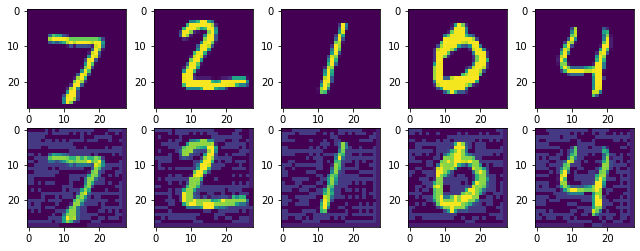

In [10]:
n = 5

f, axarr = plt.subplots(2, n, figsize=(11, 4))
for i in range(n):
    axarr[0,i].imshow(np.array(test_images[i], dtype='float').reshape((28, 28)))
    axarr[1,i].imshow(np.array(test_images_modified[i], dtype='float').reshape((28, 28)))

Dla naszego oka zmiany są niewielkie, wciąz jesteśmy w stanie dosyć łatwo zaklasyfikować każdy z obrazów do liczby, która jest przedstawiana. Sprawdzimy jednak, czy te zmiany są 'niewielkie' dla naszego modelu.

In [11]:
scores_2 = model.evaluate(x = test_images_modified, y = test_labels, verbose = 0)
print_scores(scores_2)

Accuracy:    62.98
Precision:   63.09
Recall:     62.80


Widać, że wszystkie miary jakości spadły o ponad 30 punktów procentowych, rzeczywiście nasz model jest wrażliwy na peturbacje w obrębie danych wejściowych.

## Peturbacje w obrębie wszystkich wag modelu

In [12]:
# Stworzymy sobie funkcje pomocnicze, które modyfikują (przemnażają) każdą
# wagę o losową wartość z przedziału interval

def changed_weights(layer_weights, interval = [0, 2]):
    layer = deepcopy(layer_weights)
    for i in range(len(layer[0])):
        for j in range(len(layer[0][i])):
            for k in range(len(layer[0][i][j])):
                for l in range(len(layer[0][i][j][k])):
                    layer[0][i][j][k][l] *= random.uniform(interval[0], interval[1])
    return layer

def changed_weights_2(layer_weights, interval = [0, 2]):
    layer = deepcopy(layer_weights)
    for i in range(2):
        for j in range(len(layer[0][i])):
            layer[0][i][j] *= random.uniform(interval[0], interval[1])
    return layer

In [13]:
def change_all_weights(model, interval=[0, 2]):
    new_model = models.clone_model(model)
    new_model.build((None, 10))
    new_model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    new_model.set_weights(model.get_weights())
    layer_0 = deepcopy(new_model.layers[0].get_weights())
    new_model.layers[0].set_weights(changed_weights(layer_0, interval))
    layer_2 = deepcopy(new_model.layers[2].get_weights())
    new_model.layers[2].set_weights(changed_weights(layer_2, interval))
    layer_4 = deepcopy(new_model.layers[4].get_weights())
    new_model.layers[4].set_weights(changed_weights_2(layer_4, interval))
    layer_5 = deepcopy(new_model.layers[5].get_weights())
    new_model.layers[5].set_weights(changed_weights_2(layer_5, interval))
    return new_model

In [14]:
def add_score(scores_data, scores):
    d = {'accuracy': scores[1],
        'precision': scores[2],
        'recall': scores[3]}
    return scores_data.append(d, ignore_index=True)

Pora wykonać takie modyfikacje 10-krotnie, sprawdzimy jak modyfikacja wag wpłynęła na nasze miary jakości. Ponieważ 10 wierszy to nie dużo, to na początku wyświetlimy wszystkie uzyskane wyniki.

In [15]:
scores_data = pd.DataFrame(columns=['accuracy', 'precision', 'recall'])

for i in range(10):
    scores_i = change_all_weights(model).evaluate(x = test_images, y = test_labels, verbose = 0)
    scores_data = add_score(scores_data, scores_i)
    
scores_data

,accuracy,precision,recall
0,0.9832,0.983490,0.9829
1,0.9858,0.986192,0.9856
2,0.9878,0.987996,0.9877
3,0.9853,0.985786,0.9848
4,0.9866,0.986796,0.9865
5,0.9849,0.985387,0.9845
6,0.9891,0.989297,0.9890
7,0.9827,0.983285,0.9824
8,0.9836,0.984189,0.9835
9,0.9744,0.975160,0.9736


In [16]:
scores_data.describe().drop('count')

,accuracy,precision,recall
mean,0.984340,0.984758,0.984050
std,0.004034,0.003873,0.004224
min,0.974400,0.975160,0.973600
25%,0.983300,0.983665,0.983050
50%,0.985100,0.985586,0.984650
75%,0.986400,0.986645,0.986275
max,0.989100,0.989297,0.989000


Właściwie nasz model wciąż osiąga dobre wyniki. Oczywiście dobranie przediału [0, 2] nie jest mocno ingerujące w te wagi (w końcu te losowane wartości są blisko 1). Możemy jeszcze spróbować pogorszyć wyniki korzystając z przedziału [0, 4].

In [18]:
scores_data_2 = pd.DataFrame(columns=['accuracy', 'precision', 'recall'])

for i in range(10):
    scores_i = change_all_weights(model, [0, 4]).evaluate(x = test_images, y = test_labels, verbose = 0)
    scores_data_2 = add_score(scores_data_2, scores_i)
    
scores_data_2

,accuracy,precision,recall
0,0.9525,0.952500,0.9525
1,0.9810,0.981000,0.9810
2,0.9805,0.980500,0.9805
3,0.9825,0.982500,0.9825
4,0.9788,0.978800,0.9788
5,0.9550,0.955191,0.9550
6,0.9545,0.954500,0.9545
7,0.9766,0.976600,0.9766
8,0.9848,0.984800,0.9848
9,0.9734,0.973497,0.9734


In [19]:
scores_data_2.describe().drop('count')

,accuracy,precision,recall
mean,0.971960,0.971989,0.971960
std,0.012790,0.012763,0.012790
min,0.952500,0.952500,0.952500
25%,0.959600,0.959768,0.959600
50%,0.977700,0.977700,0.977700
75%,0.980875,0.980875,0.980875
max,0.984800,0.984800,0.984800


Ponownie wyniki nie pogorszyły się aż tak bardzo. Wydaje się, że w tym obrębie nasza sieć nie jest aż tak wrażliwa. Można oczywiście pogrszyć wagi losując np. wartości z przedziału [-1, 1], ale wówczas byśmy zmieniali znak wag, a to już raczej jest zbyt dużą ingerencją w ich wartości (wówczas model nie ma prawa przewidywać poprawnie).

## Peturbacje w obrębie wag określonej warstwy

### Warstwa conv2d

Na początku spróbujemy manipulacji wagami w obrębie warstwy conv2d i sprawdzimy jakie wyniki osiągnie nasz model. Później spróbujemy także wysnuć wnioski, czy istnieje w naszym modelu warstwa, która jest najbardziej wrażliwa.

In [21]:
def change_weights_conv2d(model, interval=[0, 2]):
    new_model = models.clone_model(model)
    new_model.build((None, 10))
    new_model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    new_model.set_weights(model.get_weights())
    layer_0 = deepcopy(new_model.layers[0].get_weights())
    new_model.layers[0].set_weights(changed_weights(layer_0, interval))
    return new_model

In [22]:
scores_data_3 = pd.DataFrame(columns=['accuracy', 'precision', 'recall'])

for i in range(10):
    scores_i = change_weights_conv2d(model).evaluate(x = test_images, y = test_labels, verbose = 0)
    scores_data_3 = add_score(scores_data_3, scores_i)
    
scores_data_3.describe().drop('count')

,accuracy,precision,recall
mean,0.983060,0.983613,0.982750
std,0.005074,0.004770,0.005288
min,0.973500,0.974842,0.972600
25%,0.979850,0.980480,0.979500
50%,0.985250,0.985642,0.985100
75%,0.986875,0.987094,0.986625
max,0.988400,0.988597,0.988300


Przy peturbacjach w obrębie jednej warstwy wydaje się już bardziej uzasadnione ustawienie przedziału na np. [-1, 1]. Sprawdzimy jak bardzo wpłynie to na nasz model.

In [23]:
scores_data_4 = pd.DataFrame(columns=['accuracy', 'precision', 'recall'])

for i in range(10):
    scores_i = change_weights_conv2d(model, [-1, 1]).evaluate(x = test_images, y = test_labels, verbose = 0)
    scores_data_4 = add_score(scores_data_3, scores_i)
    
scores_data_4.describe().drop('count')

,accuracy,precision,recall
mean,0.918064,0.929211,0.893882
std,0.215622,0.180490,0.294785
min,0.268100,0.385185,0.005200
25%,0.978300,0.979074,0.977850
50%,0.984800,0.985193,0.984700
75%,0.986750,0.986993,0.986450
max,0.988400,0.988597,0.988300


Widać, że zmiana wag w obrębie jednej warstwy może bardzo znacząco wpłynąć na model - mamy bardzo niskie minimalne wyniki. Wysokie odchylenie standardowe pokazuje, że w tym przypadku wielkie znaczenie mają wylosowane wartości, co nie było aż tak widoczne przy poprzednich ewaluacjach. Oczywiście takie wyniki są także głównie spowodowane tym, że prezentowany model nie ma dużej liczby warstw (więc naturalnym wydaje się duże pogorszenie wyników modelu przy takiej ingerencji w jedną z warstw).

### Warstwa dense

In [25]:
def change_weights_dense(model, interval=[0, 2]):
    new_model = models.clone_model(model)
    new_model.build((None, 10))
    new_model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    new_model.set_weights(model.get_weights())
    layer_5 = deepcopy(new_model.layers[5].get_weights())
    new_model.layers[5].set_weights(changed_weights_2(layer_5, interval))
    return new_model

In [26]:
scores_data_5 = pd.DataFrame(columns=['accuracy', 'precision', 'recall'])

for i in range(10):
    scores_i = change_weights_dense(model).evaluate(x = test_images, y = test_labels, verbose = 0)
    scores_data_5 = add_score(scores_data_5, scores_i)
    
scores_data_5.describe().drop('count')

,accuracy,precision,recall
mean,0.989900,0.990057,0.989800
std,0.000542,0.000532,0.000533
min,0.988700,0.988799,0.988700
25%,0.989725,0.989897,0.989525
50%,0.989850,0.990046,0.989850
75%,0.990250,0.990373,0.990150
max,0.990600,0.990698,0.990500


Uzyskaliśmy dobre wyniki i małe odchylenie standardowe. Widać, że ta warstwa jest znacznie mniej wrażliwa od warstwy conv2d (porównując oczywiście z wynikami przy ustalonych przedziałach [0, 2]), może to być spowodowane na przykład tym, że warstawa conv2d jest pierwszą warstwą.

## Zjawisko niepewności w sieciach neuronowych

Niepewność w ogólności pomaga ocenić jak model jest pewny swojej predykcji. W sieciach neuronowych jest to zadanie bardzo trudne (na przykładach podczas zajęć widzieliśmy sytuacje, w których modele były na 99% pewne swoich złych decyzji ze względu na peturbacje danych). Sieci neuronowe są często bardzo wrażliwe na zaprezentowane wcześniej peturbacje, a przy ich występowaniu często niepewność modelu jest bardzo myląca. Wiążą się z tym takie metody jak na przykłada data augmentation, czyli przekształcenie zbioru treningowego dodając właśnie różne peturbacje w procesie uczenia i w ten sposób zwiększając ilość danych.

#### Źródła

* https://arxiv.org/abs/1901.07152
* https://cs.adelaide.edu.au/~javen/talk/ML05_Uncertainty_in_DL.pdf